In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess
df = pd.read_csv("QQQ.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)


In [3]:
# Feature engineering
df['daily_return'] = df['adj_close_price'].pct_change()
df['volatility_20d'] = df['daily_return'].rolling(20).std()
df['price_range'] = (df['high_price'] - df['low_price']) / df['open_price']
df['volume_change'] = df['trading_volume'].pct_change()
df['implied_price'] = df['market_cap'] / df['outstanding_shares']
df['ma_10'] = df['adj_close_price'].rolling(10).mean()
df['ma_trend'] = df['adj_close_price'] / df['ma_10'] - 1
df['target'] = (df['adj_close_price'].shift(-1) > df['adj_close_price']).astype(int)
df = df.dropna().reset_index(drop=True)

# Define features and target
features = ['adj_close_price', 'daily_return', 'volatility_20d',
            'price_range', 'volume_change', 'implied_price', 'ma_trend']
X_raw = df[features].values
y_raw = df['target'].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)



In [4]:
# Create sequences
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

seq_len = 60
X, y = create_sequences(X_scaled, y_raw, seq_len)
dates = df['date'][seq_len:].reset_index(drop=True)
prices = df['adj_close_price'][seq_len:].reset_index(drop=True)

# Train/test split
train_mask = dates <= pd.to_datetime("2023-12-31")
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]
dates_test = dates[~train_mask].reset_index(drop=True)
price_today = prices[train_mask.sum() - 1:-1].reset_index(drop=True)
price_tomorrow = prices[~train_mask].reset_index(drop=True)


In [5]:

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5487 - loss: 0.6905 - val_accuracy: 0.5692 - val_loss: 0.6862
Epoch 2/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5623 - loss: 0.6869 - val_accuracy: 0.5692 - val_loss: 0.6837
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5365 - loss: 0.6909 - val_accuracy: 0.5692 - val_loss: 0.6836
Epoch 4/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5500 - loss: 0.6888 - val_accuracy: 0.5692 - val_loss: 0.6835
Epoch 5/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5455 - loss: 0.6895 - val_accuracy: 0.5692 - val_loss: 0.6836
Epoch 6/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5433 - loss: 0.6893 - val_accuracy: 0.5723 - val_loss: 0.6857
Epoch 7/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5397 - loss: 0.6896 - val_accuracy: 0.5754 - val_loss: 0.6846
Epoch 8/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5407 - loss: 0.6905 - val_accuracy: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Signal Accuracy: 56.00%

Date		Prediction	Actual	Signal
2024-01-02	UP		DOWN	1
2024-01-03	UP		DOWN	1
2024-01-04	UP		UP	1
2024-01-05	UP		UP	1
2024-01-08	UP		UP	1
2024-01-09	UP		UP	1
2024-01-10	UP		UP	1
2024-01-11	UP		UP	1
2024-01-12	UP		DOWN	1
2024-01-16	UP		DOWN	1


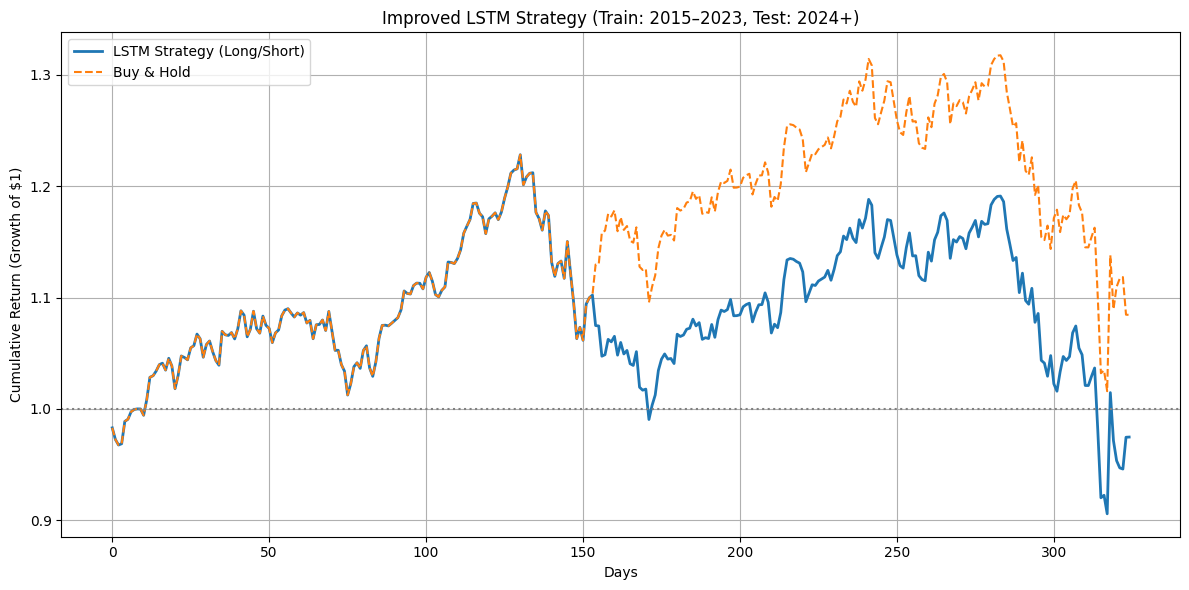

In [6]:

# Predict probabilities
probs = model.predict(X_test).flatten()
threshold = 0.52
preds = np.where(probs > threshold, 1, 0)

# Accuracy
accuracy = (preds == y_test).mean()
print(f"\nSignal Accuracy: {accuracy * 100:.2f}%")

# Show sample predictions
print("\nDate\t\tPrediction\tActual\tSignal")
for i in range(min(10, len(preds))):
    p = "UP" if preds[i] == 1 else "DOWN"
    a = "UP" if y_test[i] == 1 else "DOWN"
    print(f"{dates_test[i].date()}\t{p}\t\t{a}\t{preds[i]}")

# Strategy returns
returns = (price_tomorrow.values - price_today.values) / price_today.values
strategy_returns = np.where(preds == 1, returns, -returns)
cumulative_strategy = (1 + strategy_returns).cumprod()
buy_and_hold = (1 + returns).cumprod()

# Plot performance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='LSTM Strategy (Long/Short)', linewidth=2)
plt.plot(buy_and_hold, label='Buy & Hold', linestyle='--')
plt.axhline(1, linestyle=':', color='gray')
plt.title("Improved LSTM Strategy (Train: 2015–2023, Test: 2024+)")
plt.xlabel("Days")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()